# RGB-to-Spectra using PCA
---

\begin{itemize}
\item Compute the eigenspectra of paint pigments from the Munsell Color Chips database.
\item Convert a color camera into a spectral imager using principal components analysis.
\end{itemize}

In [634]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib import patches as patch
import scipy.io
import os
from tqdm import tqdm
import random


### Loading Datasets

In [5]:
os.chdir('G:\\My Drive\\MS Physics\\2.2\Physics-301\\Database')

#### Illuminants

In [6]:
wavelength = np.arange(400,700,.5)

CIE_A = np.loadtxt("CIE_A")
CIE_D65 = np.loadtxt("CIE_D65")
Flourescent = np.loadtxt("Flourescent")

cie = np.loadtxt("CIE1964.txt")
x_ = np.interp(wavelength, cie[:,0], cie[:,1])
y_ = np.interp(wavelength, cie[:,0], cie[:,2])
z_ = np.interp(wavelength, cie[:,0], cie[:,3])

#### Spectral Reflectances

In [680]:
'Loading Macbeth dataset'

macbeth = np.loadtxt("macbeth.txt")
macbeth_wav, macbeth_ref =  macbeth[4:64,0], macbeth[4:64,1:]

'Munsell Color Chips'

munsell_wav = np.arange(380,801,1)
munsell = np.loadtxt("munsell.txt")

### Camera Spectral Sensitivity

In [681]:

'Loading Canon 400D Spectral Sensitivity'
Canon_400D = np.loadtxt("CANON_400D")
Canon_wav, Canon_channels =  Canon_400D[:,0], Canon_400D[:,1:]

### Interpolating the datasets

In [682]:
'Interpolating the reflectances'

macbeth_r = np.zeros(shape=[len(wavelength),24])

for i in range(1,25):
    macbeth_r[:,i-1] = np.interp(wavelength, macbeth_wav, macbeth_ref[:,i-1])

munsell_r = np.zeros(shape=[len(wavelength),1269])

for i in range(1,1269):
    munsell_r[:,i] = np.interp(wavelength, munsell_wav, munsell[:,i])
    
'Interpolating the illuminant'
D65 = np.interp(wavelength, CIE_D65[:,0], CIE_D65[:,1])
Illum_A = np.interp(wavelength, CIE_A[:,0], CIE_A[:,1])

'Interpolating the Sensitivity'

Canon_red = np.interp(wavelength, Canon_wav, Canon_channels[:,0])
Canon_green = np.interp(wavelength, Canon_wav, Canon_channels[:,1])
Canon_blue = np.interp(wavelength, Canon_wav, Canon_channels[:,2])

## Spectral Trinity

### D65/Illuminant A and Canon Camera

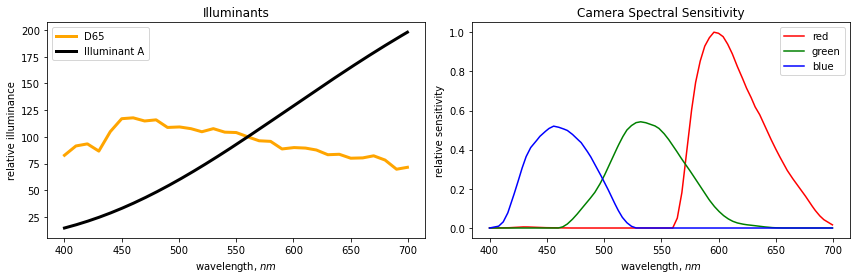

In [25]:
fig, ax = plt.subplots(1,2, figsize=[12,4])

# plt.suptitle("Spectral Trinity", fontsize = 15)

ax[0].plot(wavelength, D65, label = "D65", color = 'orange', lw = 3)
ax[0].plot(wavelength, Illum_A, label = "Illuminant A", color = 'k', lw = 3)
ax[0].set_title("Illuminants")
ax[0].set_xlabel("wavelength, $nm$")
ax[0].set_ylabel("relative illuminance")
ax[0].legend()

ax[1].set_title("Camera Spectral Sensitivity")
ax[1].plot(wavelength, Canon_red, 'r', label = "red")
ax[1].plot(wavelength, Canon_green, 'g', label = "green")
ax[1].plot(wavelength, Canon_blue, 'b',  label = "blue")
ax[1].set_ylabel("relative sensitivity")
ax[1].set_xlabel("wavelength, $nm$")
ax[1].legend()
plt.tight_layout()

### Macbeth and Munsell reflectances

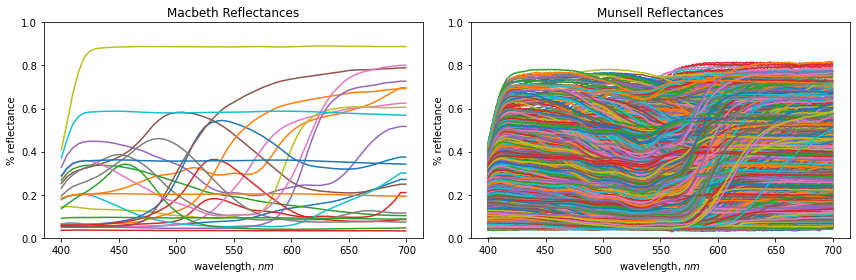

In [12]:
fig, ax = plt.subplots(1,2, figsize=[12,4])

# plt.suptitle("Spectral Trinity", fontsize = 15)

ax[0].plot(wavelength, macbeth_r)
ax[0].set_title("Macbeth Reflectances")
ax[0].set_xlabel("wavelength, $nm$")
ax[0].set_ylabel("% reflectance")
ax[0].set_ylim(0,1)


ax[1].plot(wavelength, munsell_r)
ax[1].set_title("Munsell Reflectances")
ax[1].set_xlabel("wavelength, $nm$")
ax[1].set_ylabel("% reflectance")
ax[1].set_ylim(0,1)

plt.tight_layout()

# Principal Components Analysis

### `sklearn.decomposition`: PCA package

In [27]:
from sklearn.decomposition import PCA

In [606]:
def PCA_(components):
    pca = PCA(components)
    pca.fit(munsell_r.T*D65)
    mean = pca.mean_
    eigenvector = pca.components_
    eigenvalues = pca.explained_variance_
    explained = pca.explained_variance_ratio_
    np.cumsum(explained)

    plt.figure(figsize=(8,2), dpi = 150)
    plt.subplot(121)
    plt.bar(range(1, components+1), np.cumsum(explained), 
            color = plt.cm.summer_r((np.cumsum(explained)-explained[0])/(1-explained[0])))
    plt.ylabel("cumulative sum")
    plt.xlabel("number of components")
    plt.xticks(range(0, components+1))
    plt.xlim(0, components+1)
    plt.axhline(0.95, color = 'r', ls = "--")
    plt.text(0.2, 0.88, "95% explained", color = "r")
    
    plt.subplot(122)

    for i in range(components):
        plt.plot(wavelength, eigenvector[i,:], label = str(i+1),
                 color = plt.cm.plasma(i/components), lw = 2*(components - i/2)/components)
        plt.xlabel("wavelength, $nm$")
        
    legend = plt.legend()
    legend.set_title("Eigenvector")

## Percent (%) Explained

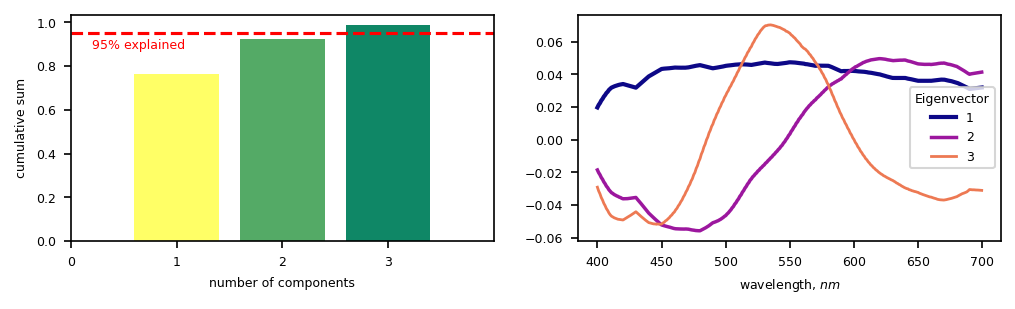

In [607]:
PCA_(components = 3)

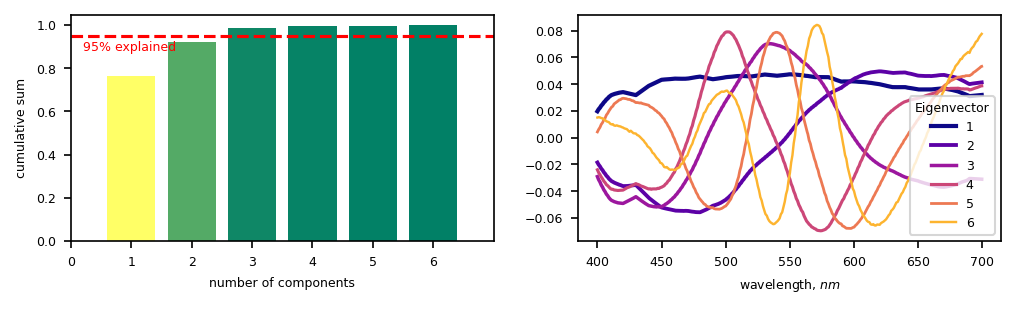

In [608]:
PCA_(components = 6)

## Number of Components

### Reconstruction visualization

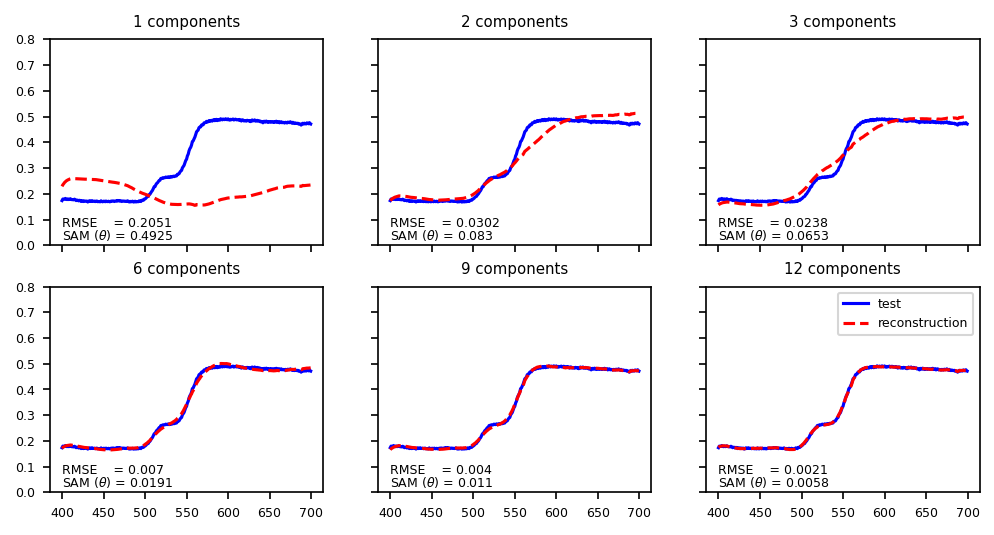

In [784]:
fig, axes = plt.subplots(2,3, figsize=(8,4), sharex=True, sharey=True, dpi=150)

xx = np.random.randint(1269)

for i, ax in enumerate(axes.ravel()):

    components = [1,2,3,6,9,12]
    
    pca = PCA(components[i])
    pca.fit(munsell_r.T)
    mean = pca.mean_
    eigenvector = pca.components_
    eigenvalues = pca.explained_variance_
    explained = pca.explained_variance_ratio_
    np.cumsum(explained)
    
    test = munsell_r[:,xx]
    test_less_mu = test - mean
    coeffs = np.dot(eigenvector, test_less_mu)
    PC = coeffs*eigenvector.T
    
    for j in range(1, components[i]):
        PC[:,0] += PC[:,j]
        reconstruction = PC[:,0] + mean
        
        
    ax.plot(wavelength, test, 'b', label = "test")
    ax.plot(wavelength, reconstruction, 'r--', label = "reconstruction")
    
    x,y = test, reconstruction
    RMSE = np.sqrt(sum((reconstruction-test)**2)/600)
    SAM = np.arccos(sum(x*y)/(np.sqrt(sum(x**2))*(np.sqrt(sum(y**2)))))
    
    ax.text(400, 0.07, "RMSE    = " + str(np.round(RMSE, 4)))
    ax.text(400, 0.02, "SAM ($\\theta$) = " + str(np.round(SAM, 4)))

    ax.set_title(str(components[i]) + " components")
    ax.set_ylim(0,0.8)
ax.legend()    
# plt.xlabel("wavelength, $nm$")
# plt.xticks([])

## Testing Macbeth using Munsell

In [787]:
RMSE = np.zeros(shape=[24,12])
SAM = np.zeros(shape=[24,12])

for xx in tqdm(range(24)):
    rmse = []
    sam = []
    for i in range(1,13):
        pca = PCA(i)
        pca.fit(munsell_r.T)
        mean = pca.mean_
        eigenvector = pca.components_
        eigenvalues = pca.explained_variance_
        explained = pca.explained_variance_ratio_
        np.cumsum(explained)

        test = macbeth_r[:,xx]
        test_less_mu = test - mean
        coeffs = np.dot(eigenvector, test_less_mu)
        PC = coeffs*eigenvector.T

        for j in range(1, i):
            PC[:,0] += PC[:,j]
            reconstruction = PC[:,0] + mean
            
        x,y = test, reconstruction
        rmse.append(np.sqrt(sum((x-y)**2)/600))
        sam.append(np.arccos(sum(x*y)/(np.sqrt(sum(x**2))*(np.sqrt(sum(y**2))))))
        
    RMSE[xx,:] = rmse
    SAM[xx,:] = sam

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.86it/s]


### Error Analysis

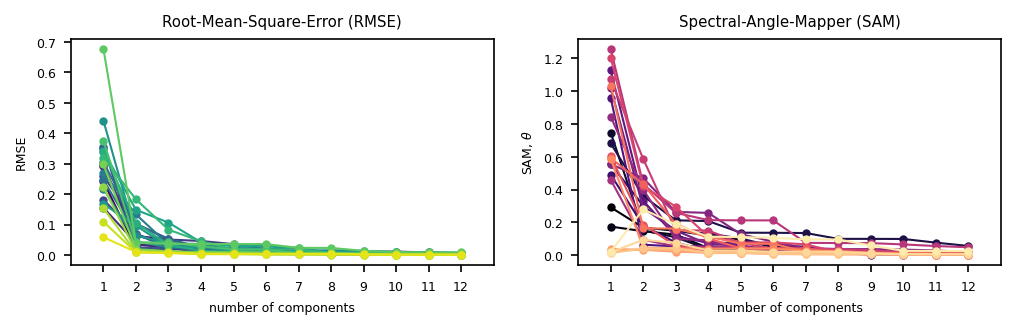

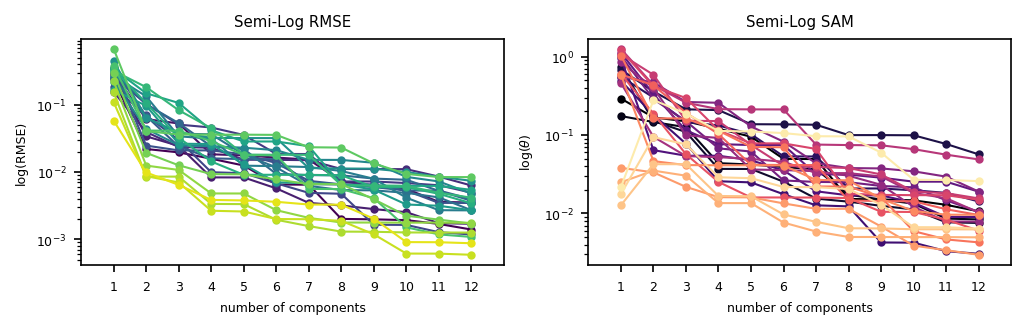

In [790]:
plt.figure(figsize=(8,2), dpi = 150)

plt.subplot(121)
plt.title("Root-Mean-Square-Error (RMSE)")
for i in range(24):
    plt.plot(range(1,13), RMSE[i].T, marker = 'o', ms = 3, lw = 1, color = plt.cm.viridis(i/24))
plt.xticks(range(1, 13))
plt.xlim(0, 13)
plt.ylabel("RMSE")
plt.xlabel("number of components")

plt.subplot(122)
plt.title("Spectral-Angle-Mapper (SAM)")
for i in range(24):
    plt.plot(range(1,13), SAM[i].T, marker = 'o', ms = 3, lw = 1, color = plt.cm.magma(i/24))
plt.xticks(range(1, 13))
plt.xlim(0, 13)
plt.ylabel("SAM, $\\theta$")
plt.xlabel("number of components")
plt.show()


plt.figure(figsize=(8,2), dpi = 150)

plt.subplot(121)
plt.title("Semi-Log RMSE")
for i in range(24):
    plt.plot(range(1,13), RMSE[i].T, marker = 'o', ms = 3, lw = 1, color = plt.cm.viridis(i/24))
plt.yscale("log")
plt.xticks(range(1, 13))
plt.xlim(0, 13)
plt.ylabel("log(RMSE)")
plt.xlabel("number of components")

plt.subplot(122)
plt.title("Semi-Log SAM")
for i in range(24):
    plt.plot(range(1,13), SAM[i].T, marker = 'o', ms = 3, lw = 1, color = plt.cm.magma(i/24))
plt.yscale("log")
plt.xticks(range(1, 13))
plt.xlim(0, 13)
plt.ylabel("log($\\theta$)")
plt.xlabel("number of components")
plt.show()

### $\Delta E_{76}$: Color Difference Metric

In [794]:
def f(t):
    if t > (6/29)**3:
        return t**(1/3)
    else:
        return (((29/6)**2)/3)*t + 4/29
    
def CIELab(spectrum):

    X_n = np.trapz(D65*x_)
    Y_n = np.trapz(D65*y_)
    Z_n = np.trapz(D65*z_)
    
    X = np.trapz(spectrum*D65*x_)
    Y = np.trapz(spectrum*D65*y_)
    Z = np.trapz(spectrum*D65*z_)
        
    L = 116*f(Y/Y_n)-16
    a = 500*(f(X/X_n)-f(Y/Y_n))
    b = 200*(f(Y/Y_n)-f(Z/Z_n))

    return L,a,b

def del_E(LAB_1,LAB_2):
    d_e = np.sqrt((LAB_1[0]-LAB_2[0])**2 + (LAB_1[1]-LAB_2[1])**2 + (LAB_1[2]-LAB_2[2])**2)
    return d_e

# Transformation Matrix

In [791]:
def PrincipalCA(components, ensemble):
    pca = PCA(components)
    pca.fit(ensemble)
    mean = pca.mean_
    eigenvector = pca.components_
    eigenvalues = pca.explained_variance_
    
    return mean, eigenvector, eigenvalues

components = 3
ensemble = munsell_r.T
source = D65


In [793]:

r_sensitivity, g_sensitivity, b_sensitivity
mean, eigenvector, eigenvalues = PrincipalCA(components, munsell_r.T)

T = np.zeros(shape=[components,components])

for j in range(3):
    T[0,j] = np.trapz(source*r_sensitivity*eigenvector[j])
    T[1,j] = np.trapz(source*g_sensitivity*eigenvector[j])
    T[2,j] = np.trapz(source*b_sensitivity*eigenvector[j])
    
T_inv = np.linalg.inv(T)

T, T_inv

In [821]:
plt.rcParams.update({'font.size': 6})

def Color_Simulation(r_sensitivity,g_sensitivity,b_sensitivity, source):
    
    components = 3
    
    mean, eigenvector, eigenvalues = PrincipalCA(components, munsell_r.T)

    T = np.zeros(shape=[components,components])

    for j in range(3):
        T[0,j] = np.trapz(source*r_sensitivity*eigenvector[j])
        T[1,j] = np.trapz(source*g_sensitivity*eigenvector[j])
        T[2,j] = np.trapz(source*b_sensitivity*eigenvector[j])

    T_inv = np.linalg.inv(T)
    
    fig, axes = plt.subplots(4,6, figsize=(8,5), sharex=True, sharey=True, dpi=150)

    left, bottom, width, height = [0.655,0.9, 0.11, 0.1]
    ax0 = fig.add_axes([left, bottom, width, height])
    ax0.plot(wavelength, source, color = 'orange', lw = 1, label = 'Source' )
    ax0.plot(wavelength, Canon_red, 'r--', lw = 0.5, label = "Canon Red")
    ax0.plot(wavelength, Canon_green, 'g--', lw = 0.5, label = "Canon Red")
    ax0.plot(wavelength, Canon_blue, 'b--', lw = 0.5, label = "Canon Red")
    ax0.set_xticks([0])
    
    R_m_w = np.trapz(macbeth_r[:,18]*r_sensitivity*source)
    G_m_w = np.trapz(macbeth_r[:,18]*g_sensitivity*source)
    B_m_w = np.trapz(macbeth_r[:,18]*b_sensitivity*source)
    #print("Macbeth RGB: ", R_m_w, G_m_w, B_m_w)

    c = np.matmul(T_inv, np.array([R_m_w,G_m_w,B_m_w]))
    rec_w = sum((c.T*eigenvector.T).T).T

    R_w = np.trapz(rec_w*r_sensitivity*source)
    G_w = np.trapz(rec_w*g_sensitivity*source)
    B_w = np.trapz(rec_w*b_sensitivity*source)
    #print("Reconstruced RGB: ", R_w, G_w, B_w)

    scaling_factor = R_m_w/R_w
    
    for i, ax in enumerate(axes.ravel()):
        
        R = np.trapz(macbeth_r[:,i]*r_sensitivity*source)
        G = np.trapz(macbeth_r[:,i]*g_sensitivity*source)
        B = np.trapz(macbeth_r[:,i]*b_sensitivity*source)

        rr,gg,bb = R/R_m_w,G/G_m_w,B/B_m_w

        ax.set_facecolor(([rr,gg,bb]))
        
        c = np.matmul(T_inv, np.array([R*scaling_factor,G*scaling_factor,B*scaling_factor]))
        rec = sum((c.T*eigenvector.T).T).T
        actual = macbeth_r[:,i]
        
        
        ax.plot(wavelength, actual*source, 'b-', label = "Actual")
        ax.plot(wavelength, rec*source, 'r--', label = "Reconstructed")
        
        RMSE = np.sqrt(sum((rec-actual)**2)/600)
#         ax.set_xlabel(round(RMSE,3))
        
        de_76 = del_E(CIELab(actual),CIELab(rec))
        
        ax.set_xlabel("$\Delta E_{76} = $" + str(np.round(de_76,2)))

    ax.legend()
    legend = ax.legend(bbox_to_anchor=(1.2,0.8), fancybox = True)

    legend = ax0.legend(bbox_to_anchor=(1,1.1), fancybox = True)
    frame = legend.get_frame() #sets up for color, edge, and transparency
    frame.set_facecolor('#b4aeae') #color of legend
    frame.set_edgecolor('black') #edge color of legend
    frame.set_alpha(0.6) #deals with transparency
    return RGB

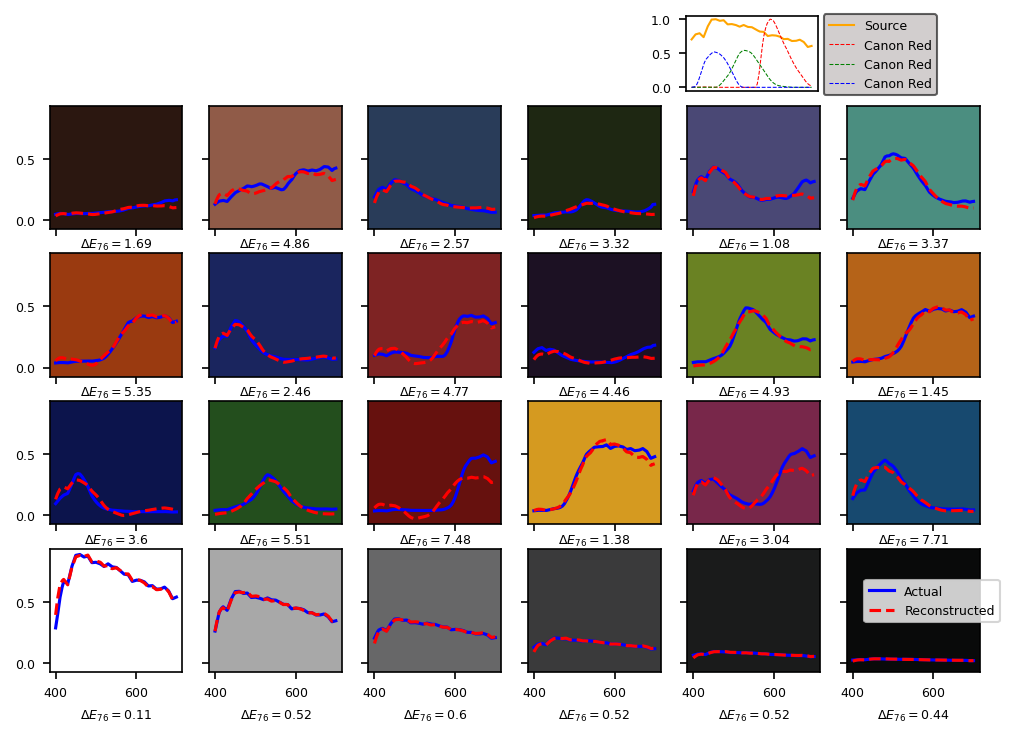

In [822]:
macbeth_rgb = Color_Simulation(Canon_red,Canon_green,Canon_blue, D65/D65.max())

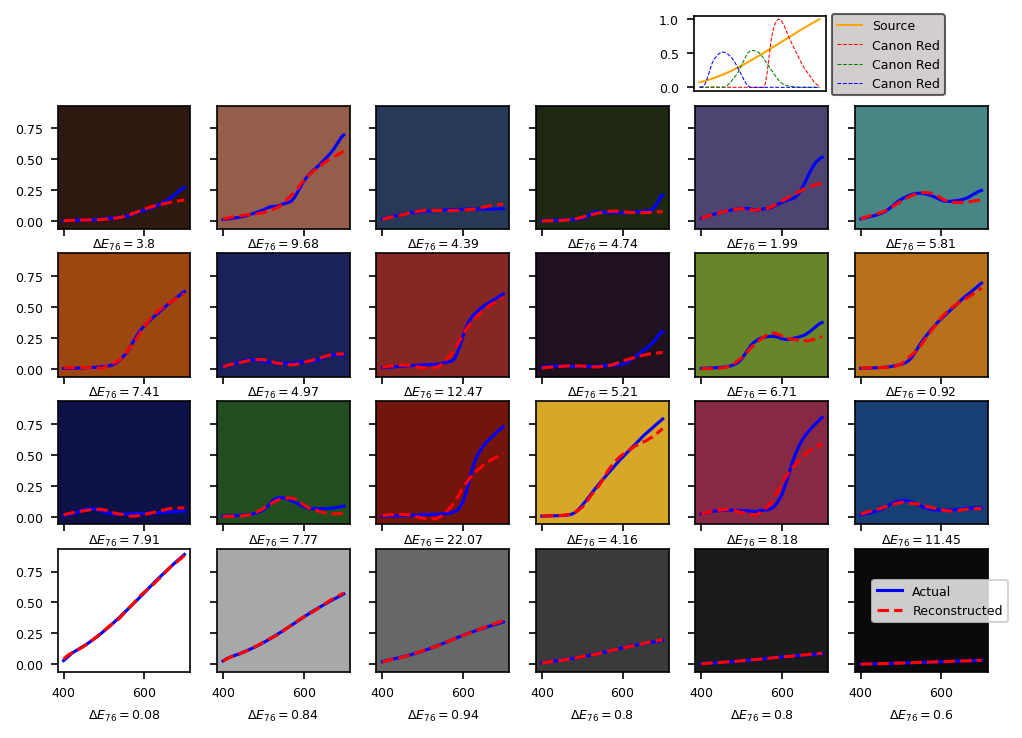

In [823]:
macbeth_rgb = Color_Simulation(Canon_red,Canon_green,Canon_blue, Illum_A/Illum_A.max())

ValueError: x and y must have same first dimension, but have shapes (600,) and (1,)

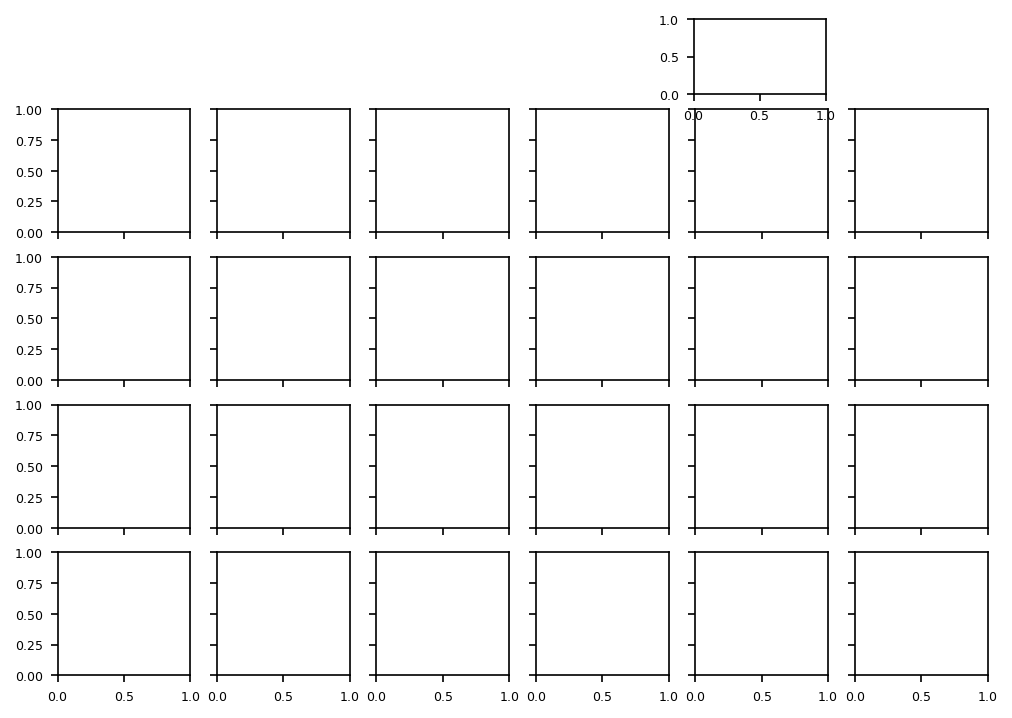

In [802]:
macbeth_rgb = Color_Simulation(Canon_red,Canon_green,Canon_blue, 1)

In [ ]:
macbeth_rgb = Color_Simulation(Canon_red,Canon_green,Canon_blue, 1)

In [273]:
x = munsell_r[:,:]
y = np.transpose(x)
R_ss = np.matmul(x,y)
H = np.zeros(shape=[3,600])
source = D65/D65.max()
H[0,:] = source*Canon_red
H[1,:] = source*Canon_green
H[2,:] = source*Canon_blue
Q = np.matmul(R_ss,np.matmul(H.T,np.linalg.inv(np.matmul(H,np.matmul(R_ss,H.T)))))

'First Order' 'Q = [600,3]'
R_v, G_v, B_v = Q[:,0], Q[:,1], Q[:,2]

'Second Order' 'Q6 = [600, 6]'
Q6 = np.array([R_v*G_v, R_v*B_v, G_v*B_v, R_v*R_v, G_v*G_v, B_v*B_v]).T

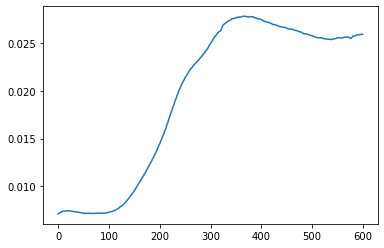

In [274]:
C = macbeth_rgb[0]
reconstruction = np.matmul(Q,C)
plt.plot(reconstruction)

Average RMSE = 0.26093 (STD = 0.151634)


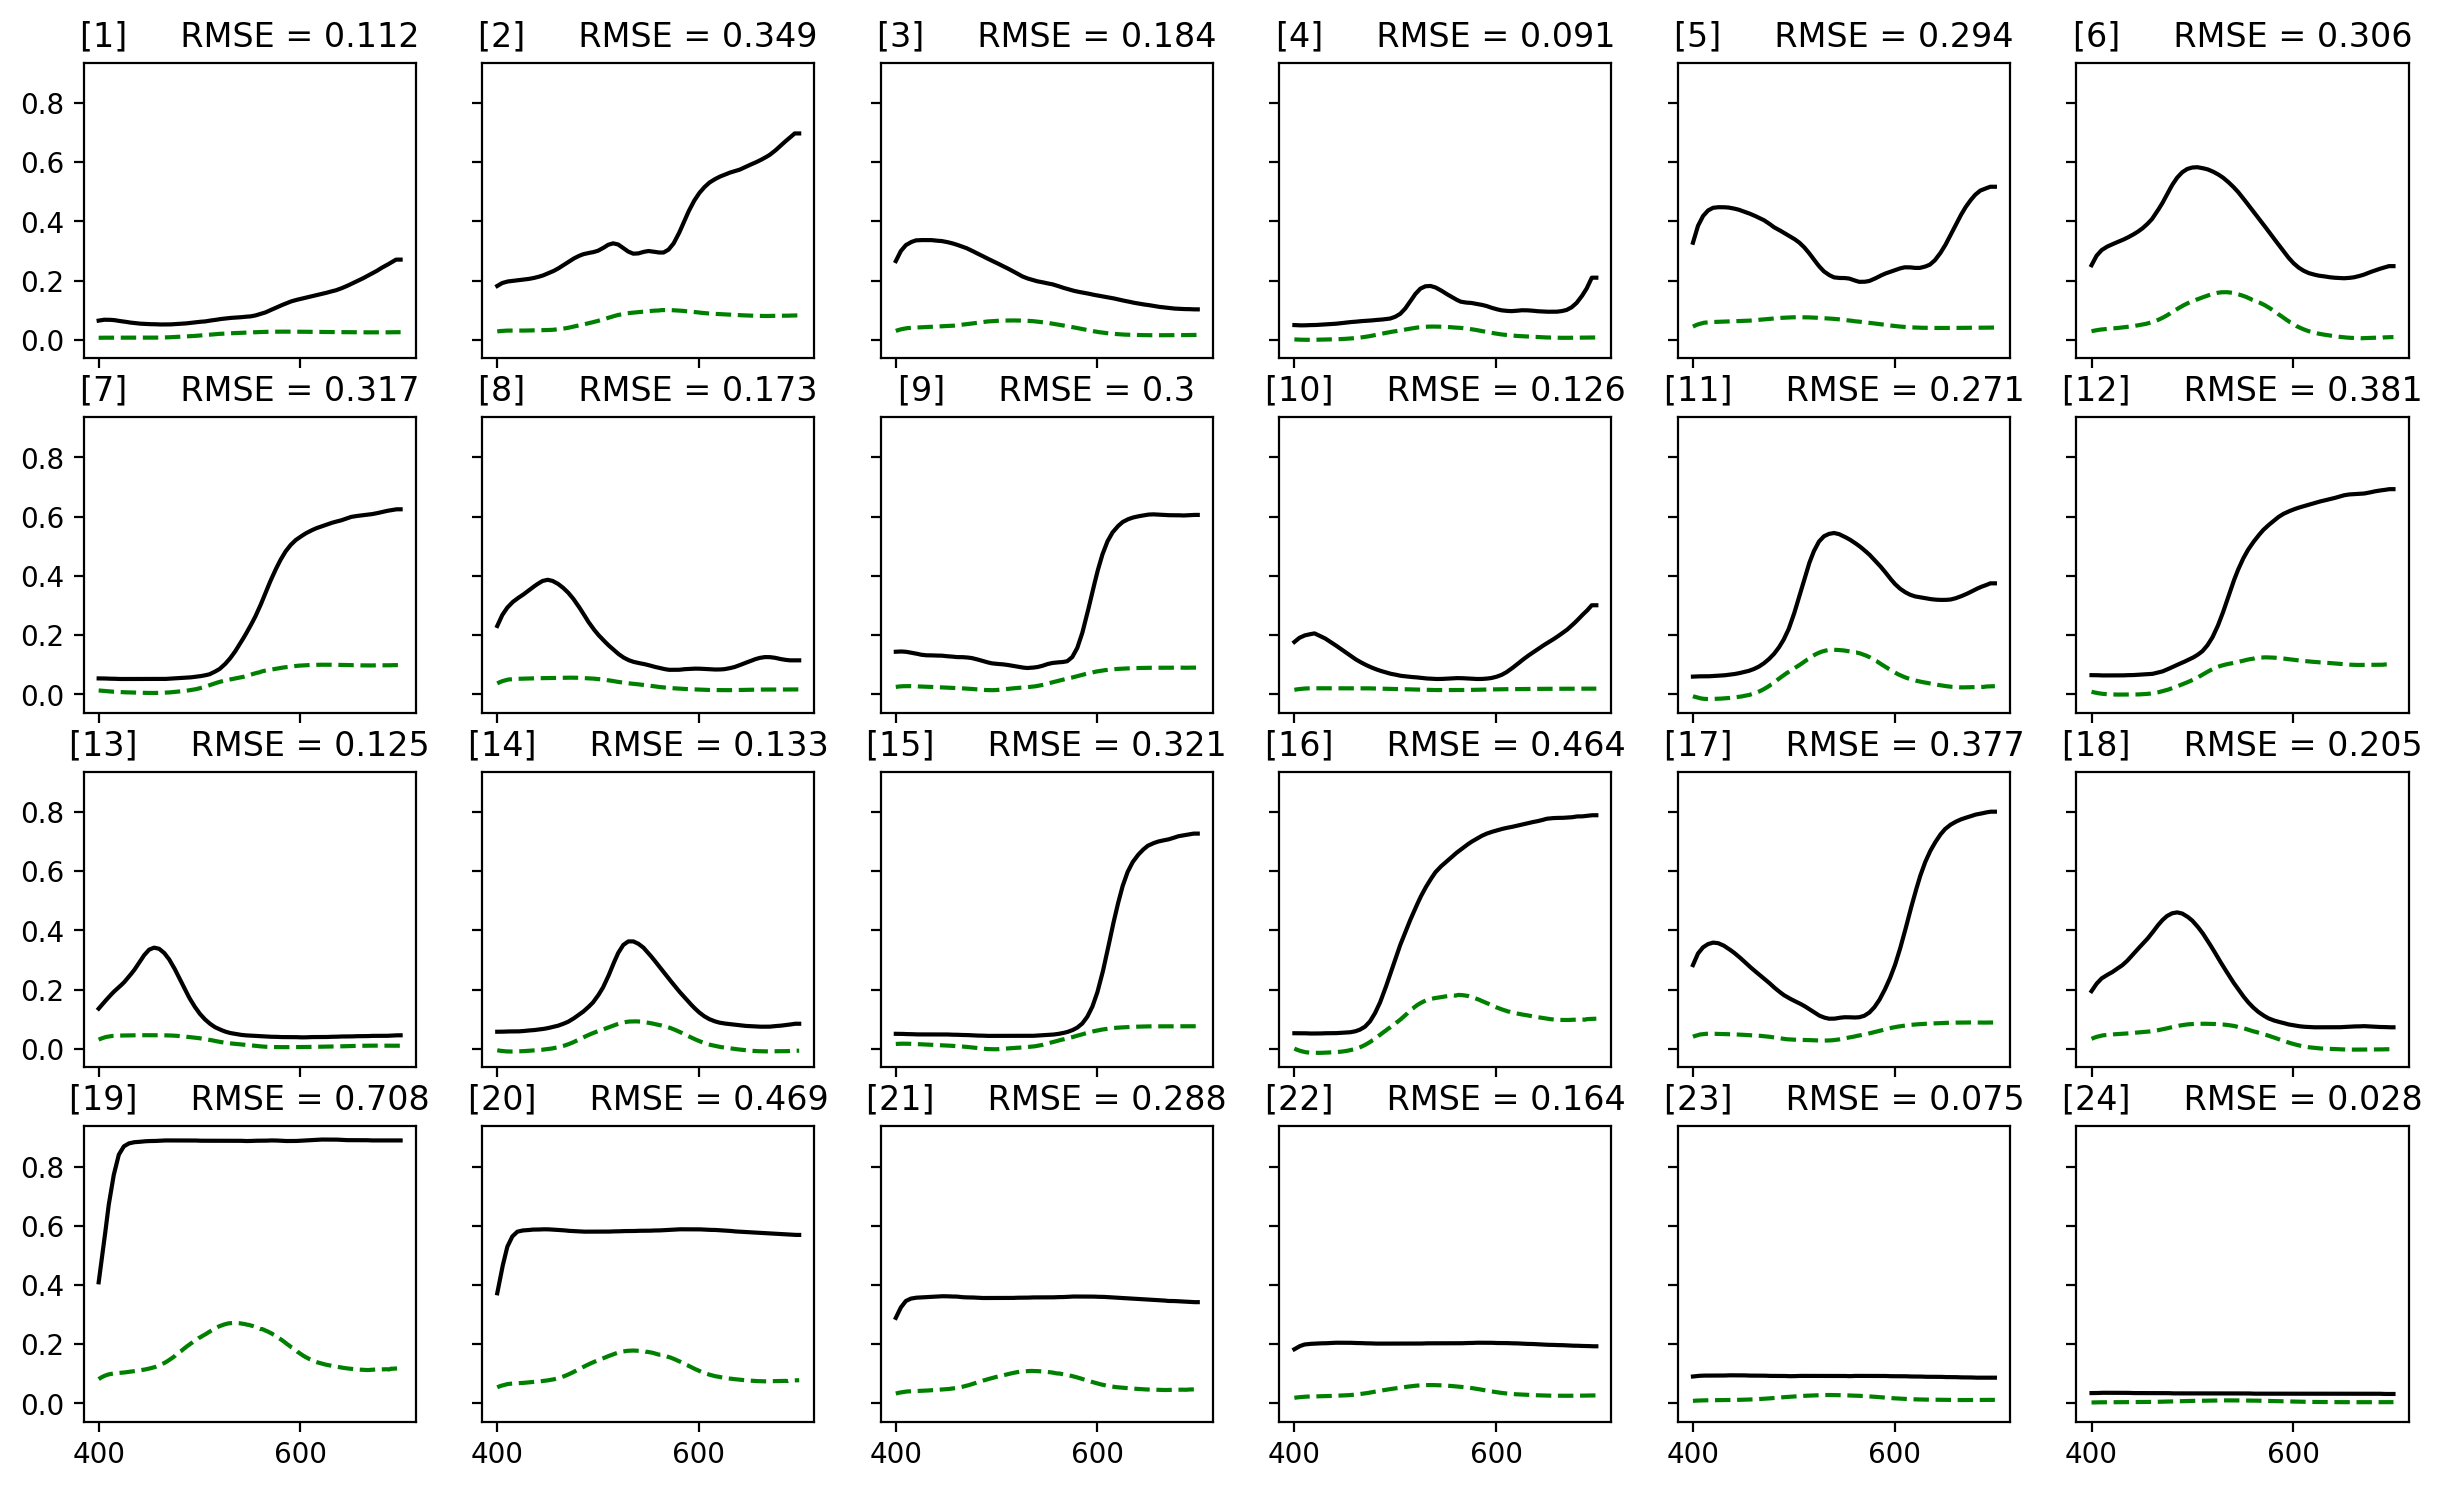

In [275]:
def Wiener_Est(Q):
    errors = []

    fig, axes = plt.subplots(4,6, figsize=(15,9), sharex=True, sharey=True, dpi=200, facecolor = 'w')
    for i, ax in enumerate(axes.ravel()):
        
        C = macbeth_rgb[i]
        plt.subplot(4,6,i+1)
        test = macbeth_r[:,i]
        reconstruction = np.matmul(Q,C)
        RMSE = np.sqrt(sum((reconstruction-test)**2)/600)
        errors.append(RMSE)
        plt.plot(wavelength, test, 'k-', wavelength, reconstruction, 'g--', aa=True)
        plt.title('[' + str(i+1)+ ']     ' + 'RMSE = ' + str(round(RMSE,3)))
    mean_error, std_error = np.mean(errors), np.std(errors)
    return mean_error, std_error

mean, std = Wiener_Est(Q)
print('Average RMSE = ' + str(round(mean,6)) + ' (STD = ' + str(round(std,6)) + ')')